In [1]:
import pandas
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

In [2]:
usd_rate = pandas.read_excel("usd_rate.xlsx")
curs = usd_rate.curs
future = 7 # Попытаемся предсказать курс на 7 дней вперед
past = 14 # На основе 14 дней в прошлом
start = past
end = len(curs) - future

In [3]:
raw_df = [list(curs[(day-past):(day+future)]) for day in range(start, end)]

In [4]:
past_columns = [f"past_{i}" for i in range(past)]
past_columns

['past_0',
 'past_1',
 'past_2',
 'past_3',
 'past_4',
 'past_5',
 'past_6',
 'past_7',
 'past_8',
 'past_9',
 'past_10',
 'past_11',
 'past_12',
 'past_13']

In [5]:
future_columns = [f"future_{i}" for i in range(future)]
future_columns

['future_0',
 'future_1',
 'future_2',
 'future_3',
 'future_4',
 'future_5',
 'future_6']

In [6]:
total_columns = past_columns + future_columns
df = pandas.DataFrame(data=raw_df, columns=total_columns)

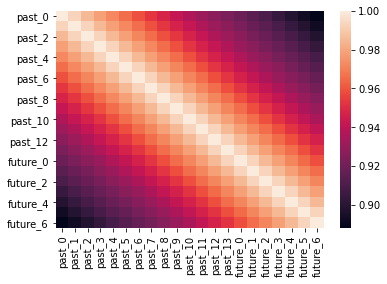

In [7]:
# для анализа надежности и доверительности модели следует проверить уровень корреляции между составляющими датасета.
# С учетом того, что автомасштабирование коэффициентов корреляции находитcz в пределах 1 - 0.9, то это означает, что корреляция достатолчно высокая корреляция между величинами
# Как правило из модели features с большой корреляцией между собой надо убирать - 
# соответственно надежность прогнозов при такой высокой корреляции будет крайне низкой
sns.heatmap(df.corr())

In [8]:
# Обучающая выборка (тренировочная) "Учебник"
X = df[past_columns][:-1]
Y = df[future_columns][:-1]

In [9]:
# Проверочная (тестовая) выборка, "Экзамен"
X_test = df[past_columns][-1:]
Y_test = df[future_columns][-1:]

In [ ]:
lr = LinearRegression() # Настройки
lr.fit(X,Y) # Обучение
prediction = lr.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction")
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mean_absolute_error(prediction[0], Y_test.iloc[0])

In [ ]:
KNN = KNeighborsRegressor(n_neighbors=2)
KNN.fit(X,Y)
prediction = KNN.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction[0], Y_test.iloc[0])
print(f"MAE = {mae}")

In [ ]:
# Использовать датасет из эфира (будет выложен в ТГ)
# Использовать random_state=42
# 1. Документция по Sklearn https://scikit-learn.org/stable/modules/classes.html
# 2. Подобрать параметры MLPRegressor, добиться MAE (mean_absolute_error) меньше чем в эфире 0.924
# 3. Выбрать из sklearn 4 (четыре) других модели регресии 
# (...Regressor, модели которые мы еще НЕ испольовали), 
# и добиться на них наименьшей ошибки. 

# Критерием оценки ДЗ НЕ ЯВЛЯЕТСЯ самая минимальная ошибки.
# 4. Оформить свой результат в виде HTML файла (Меню File -> Download as -> HTML), 
# в файле должно быть
# — Комментарии к коду, что вы делаете в этом коде и зачем
# — Графики (https://matplotlib.org/gallery/index.html)
# — В отчете должны быть выводы

# Дз нужно прислать до 18:00 МСК завтра(ВС), что бы мы успели все проверить
# Ссылка куда прислать будет в ТГ

In [10]:
mlpr = MLPRegressor(random_state=42)

In [ ]:
# как правило очень большое влияние в моделях на основе нейростей играют 
# - функции активации 
# - оптимизаторы (solver)
# - конфигурация скрытых слоёв
# - количество итераций для оптимизатора для достижения сходимости
params = dict(
    activation= ["tanh", "relu"],
    hidden_layer_sizes= [(x, y) for x in range(200, 601, 100) for y in range(200, 601, 100)],
    max_iter= [100, 200, 400, 1000],
    solver= ["sgd", "adam"]
)

grid = GridSearchCV(estimator=mlpr, param_grid=params, cv=3, verbose=0)
# посмотреть на время, которое потребуется для поиска оптимальных параметров
d1 = datetime.now()
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    grid_result = grid.fit(X, Y)

d2 = datetime.now()
delta = d2 - d1
print("fitting time - {} seconds".format(delta.seconds))

# вывод наиболее удачной комбинации параметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
prediction = grid_result.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction[0], Y_test.iloc[0])
print(f"MAE = {mae}")

In [10]:
bagging_regressor = BaggingRegressor(random_state=42)

fitting time - 22 seconds
Best: -1.213643 using {'n_estimators': 10}
-1.247677 (1.985253) with: {'n_estimators': 5}
-1.213643 (1.916373) with: {'n_estimators': 10}
-1.264073 (1.889933) with: {'n_estimators': 15}
-1.305518 (1.859177) with: {'n_estimators': 20}
-1.274164 (1.896512) with: {'n_estimators': 25}
-1.311302 (1.889476) with: {'n_estimators': 30}
-1.344905 (1.879786) with: {'n_estimators': 35}
-1.329803 (1.832141) with: {'n_estimators': 40}
-1.361327 (1.861523) with: {'n_estimators': 45}
-1.368098 (1.905581) with: {'n_estimators': 50}
-1.307129 (1.860562) with: {'n_estimators': 55}
-1.326607 (1.875733) with: {'n_estimators': 60}
-1.315379 (1.860341) with: {'n_estimators': 65}
-1.334810 (1.872573) with: {'n_estimators': 70}
-1.376496 (1.906783) with: {'n_estimators': 75}
-1.339621 (1.893911) with: {'n_estimators': 80}
-1.342388 (1.902933) with: {'n_estimators': 85}
-1.364028 (1.912601) with: {'n_estimators': 90}
-1.380586 (1.916227) with: {'n_estimators': 95}
-1.387950 (1.927620)

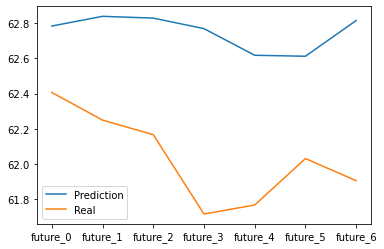

In [15]:
# попробуем оптимизировать количество эстиматоров 
params = dict(
    n_estimators=[x for x in range(1,20)]
)

grid = GridSearchCV(estimator=bagging_regressor, param_grid=params, cv=3, verbose=0)
# посмотреть на время, которое потребуется для поиска оптимальных параметров
d1 = datetime.now()
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    grid_result = grid.fit(X, Y)

d2 = datetime.now()
delta = d2 - d1
print("fitting time - {} seconds".format(delta.seconds))

# вывод наиболее удачной комбинации параметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
prediction = grid_result.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction[0], Y_test.iloc[0])
print(f"MAE = {mae}")

In [19]:
rf_regressor = RandomForestRegressor(random_state=42)

fitting time - 22 seconds
Best: -1.125626 using {'n_estimators': 5}
-1.125626 (1.894833) with: {'n_estimators': 5}
-1.194881 (1.940639) with: {'n_estimators': 10}
-1.285400 (1.934674) with: {'n_estimators': 15}
-1.329361 (1.885480) with: {'n_estimators': 20}
-1.259482 (1.902629) with: {'n_estimators': 25}
-1.317302 (1.917856) with: {'n_estimators': 30}
-1.306005 (1.889663) with: {'n_estimators': 35}
-1.326715 (1.870988) with: {'n_estimators': 40}
-1.316221 (1.879451) with: {'n_estimators': 45}
-1.310424 (1.901598) with: {'n_estimators': 50}
-1.258546 (1.860500) with: {'n_estimators': 55}
-1.224615 (1.832636) with: {'n_estimators': 60}
-1.204536 (1.799011) with: {'n_estimators': 65}
-1.214091 (1.793910) with: {'n_estimators': 70}
-1.250253 (1.816643) with: {'n_estimators': 75}
-1.243111 (1.792007) with: {'n_estimators': 80}
-1.256676 (1.810269) with: {'n_estimators': 85}
-1.264824 (1.801076) with: {'n_estimators': 90}
-1.287348 (1.811224) with: {'n_estimators': 95}
-1.310798 (1.824264) 

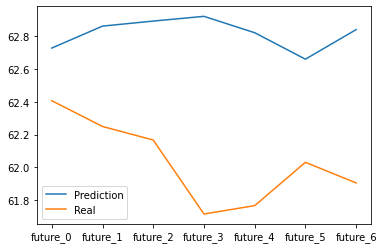

In [20]:
# попробуем оптимизировать количество эстиматоров 
params = dict(
    n_estimators=[x for x in range(1,20)]
)

grid = GridSearchCV(estimator=rf_regressor, param_grid=params, cv=3, verbose=0)
# посмотреть на время, которое потребуется для поиска оптимальных параметров
d1 = datetime.now()
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    grid_result = grid.fit(X, Y)

d2 = datetime.now()
delta = d2 - d1
print("fitting time - {} seconds".format(delta.seconds))

# вывод наиболее удачной комбинации параметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
prediction = grid_result.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction[0], Y_test.iloc[0])
print(f"MAE = {mae}")

In [22]:
ab_regressor = AdaBoostRegressor(random_state=42)

In [23]:
# попробуем оптимизировать количество эстиматоров 
params = dict(
    n_estimators=[x for x in range(5,151, 5)]
)

grid = GridSearchCV(estimator=ab_regressor, param_grid=params, cv=3, verbose=0)
# посмотреть на время, которое потребуется для поиска оптимальных параметров
d1 = datetime.now()
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    grid_result = grid.fit(X, Y)

d2 = datetime.now()
delta = d2 - d1
print("fitting time - {} seconds".format(delta.seconds))

# вывод наиболее удачной комбинации параметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
prediction = grid_result.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction[0], Y_test.iloc[0])
print(f"MAE = {mae}")

ValueError: bad input shape (719, 7)

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
X_1, y_1 = make_regression(random_state=0)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, random_state=0)

In [28]:
X_train.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [26]:
y.shape

(100,)